In [172]:
import tensorflow as tf
print(tf.__version__)


2.15.0


# TRAINING

## Global constants

In [173]:
# Set to True for inference only, False for training
ONLY_INFERENCE = True

# Configuration for model training
FOLDS = 5
EPOCHS = 4
BATCH = 32
NAME = 'None'

SPEC_SIZE  = (512, 512, 3)
CLASSES = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
N_CLASSES = len(CLASSES)
TARGETS = CLASSES

IMPORTS

In [174]:
!pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
efficientnet is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [175]:
import gc
import os
import random
import sys
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras import backend as K
from tqdm import tqdm 
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt, iirnotch
from scipy.signal import spectrogram as spectrogram_np

import efficientnet.tfkeras as efn

sys.path.append(f'/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

In [176]:
%%time
!nvidia-smi

# Installation of RAPIDS to Use cuSignal
!cp ../input/rapids/rapids.0.17.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
!rm /opt/conda/envs/rapids.tar.gz

sys.path += ["/opt/conda/envs/rapids/lib/python3.7/site-packages"]
sys.path += ["/opt/conda/envs/rapids/lib/python3.7"]
sys.path += ["/opt/conda/envs/rapids/lib"]
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

import cupy as cp
import cusignal

Thu Mar 28 22:17:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0              29W /  70W |  14077MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Environment functions

In [177]:
# Set the visible CUDA devices
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# Set the strategy for using GPUs
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <= 1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

# Configure memory growth
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Enable or disable mixed precision
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Using 2 GPUs
Physical devices cannot be modified after being initialized
Mixed precision enabled


In [178]:
# Function to set random seed for reproducibility
def set_random_seed(seed: int = 42, deterministic: bool = False):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    if deterministic:
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
    else:
        os.environ.pop('TF_DETERMINISTIC_OPS', None)

# Set a deterministic behavior
set_random_seed(deterministic=True)

## Data

In [179]:
def create_train_data():
    # Read the dataset
    df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
    
    # Create a new identifier combining multiple columns
    id_cols = ['eeg_id', 'spectrogram_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    df['new_id'] = df[id_cols].astype(str).agg('_'.join, axis=1)
    
    # Calculate the sum of votes for each class
    df['sum_votes'] = df[CLASSES].sum(axis=1)
    
    # Group the data by the new identifier and aggregate various features
    agg_functions = {
        'eeg_id': 'first',
        'eeg_label_offset_seconds': ['min', 'max'],
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'spectrogram_id': 'first',
        'patient_id': 'first',
        'expert_consensus': 'first',
        **{col: 'sum' for col in CLASSES},
        'sum_votes': 'mean',
    }
    grouped_df = df.groupby('new_id').agg(agg_functions).reset_index()

    # Flatten the MultiIndex columns and adjust column names
    grouped_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in grouped_df.columns]
    grouped_df.columns = grouped_df.columns.str.replace('_first', '').str.replace('_sum', '').str.replace('_mean', '')
    
    # Normalize the class columns
    y_data = grouped_df[CLASSES].values
    y_data_normalized = y_data / y_data.sum(axis=1, keepdims=True)
    grouped_df[CLASSES] = y_data_normalized

    # Split the dataset into high and low quality based on the sum of votes
    high_quality_df = grouped_df[grouped_df['sum_votes'] >= 10].reset_index(drop=True)
    low_quality_df = grouped_df[(grouped_df['sum_votes'] < 10) & (grouped_df['sum_votes'] >= 0)].reset_index(drop=True)

     # CREATE NON-OVERLAPPING EEG ID TRAIN DATA
    train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
        {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
    train.columns = ['spec_id','min']
    
    tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
        {'spectrogram_label_offset_seconds':'max'})
    train['max'] = tmp
    
    tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
    train['patient_id'] = tmp
    
    tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
    for t in TARGETS:
        train[t] = tmp[t].values
    
    y_data = train[TARGETS].values
    y_data = y_data / y_data.sum(axis=1,keepdims=True)
    train[TARGETS] = y_data
    
    tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
    train['target'] = tmp
    
    train = train.reset_index()
    print('Train non-overlapping eeg_id shape:', train.shape )
    train.head()
    
    return high_quality_df, low_quality_df

# Call the function to create train data
high_quality_train, low_quality_train = create_train_data()

Train non-overlapping eeg_id shape: (17089, 12)


In [180]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, data, batch_size=32, shuffle=False, mode='train'):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mode = mode
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch."""
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        """Generates data containing batch_size samples."""
        # Initialization
        X = np.zeros((len(indexes), *SPEC_SIZE), dtype='float32')
        y = np.zeros((len(indexes), len(CLASSES)), dtype='float32')

        # Generate data
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            eeg_id = row['eeg_id']
            spec_offset = int(row['spectrogram_label_offset_seconds_min'])
            eeg_offset = int(row['eeg_label_offset_seconds_min'])
            file_path = f'/kaggle/input/3-diff-time-specs-hms/images/{eeg_id}_{spec_offset}_{eeg_offset}.npz'
            data = np.load(file_path)
            eeg_data = data['final_image']
            eeg_data_expanded = np.repeat(eeg_data[:, :, np.newaxis], 3, axis=2)

            X[j] = eeg_data_expanded
            if self.mode != 'test':
                y[j] = row[CLASSES]

        return X, y

## Model

In [181]:
def lrfn(epoch):
    lr_schedule = [1e-3, 1e-3, 1e-3, 1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5]
    return lr_schedule[epoch]

# Define the learning rate scheduler callback
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

def build_EfficientNetB0(input_shape=(512, 512, 3), num_classes=6):
    inp = tf.keras.Input(shape=input_shape)

    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)
    base_model.load_weights(f'/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')

    # OUTPUT
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes,activation='softmax', dtype='float32')(x)

    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer = opt)

    return model

## cross_validate_model - Label Refine

In [182]:
def cross_validate_model(train_data, train_data_2, folds, random_seed, targets, nome_modelo):
    inicio = time.time()
    path_model = f'MLP_Model{nome_modelo}'
    if not os.path.exists(path_model):
        os.makedirs(path_model)

    all_oof = []
    all_oof2 = []
    all_true = []
    models = []
    score_list = []
    
    # Separating the data to iterate over both dataframes simultaneously
    gkf = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=random_seed)
    splits1 = list(gkf.split(train_data, train_data[["expert_consensus"]], train_data["patient_id"]))
    splits2 = list(gkf.split(train_data_2, train_data_2[["expert_consensus"]], train_data_2["patient_id"]))

    # Iterate over folds in parallel
    for i, ((train_index, valid_index), (train_index2, valid_index2)) in enumerate(zip(splits1, splits2)):
        
        # Copy the dataframes to avoid leaks
        train_data_ = train_data.copy()
        train_data_2_ = train_data_2.copy()
        set_random_seed(random_seed, deterministic=True)
        
        # Start folding
        print('#' * 25)
        print(f'### Fold {i + 1}')
        print(f'### train size 1 {len(train_index)}, valid size {len(valid_index)}')
        print(f'### train size 2 {len(train_index2)}, valid size {len(valid_index2)}')
        print('#' * 25)

        ### --------------------------- Performs model 1 training -------------- --------------------------- ###
        K.clear_session()
        train_gen = DataGenerator(train_data_.iloc[train_index], shuffle=True, batch_size=BATCH)
        valid_gen = DataGenerator(train_data_.iloc[valid_index], shuffle=False, batch_size=(BATCH*2), mode='valid')
        model = build_EfficientNetB0(input_shape=(512, 512, 3), num_classes=6)
        history = model.fit(train_gen, verbose=2, validation_data=valid_gen, epochs=EPOCHS, callbacks=[LR])

        # Model training result 1
        train_loss = history.history['loss'][-1]  
        valid_loss = history.history['val_loss'][-1]
        print(f'train_loss 1 {train_loss} valid_loss 1 {valid_loss}')
        score_list.append((train_loss, valid_loss))

        
        ### --------------------------- creation of pseudo labels ---------------- ------------------------- ###
        # pseudo labels for low quality data
        train_2_index_total_gen = DataGenerator(train_data_2_.iloc[train_index2], shuffle=False, batch_size=BATCH)
        pseudo_labels_2 = model.predict(train_2_index_total_gen, verbose=2)
        # Refinement of low quality labels
        train_data_2_.loc[train_index2, TARGETS] /= 2
        train_data_2_.loc[train_index2, TARGETS] += pseudo_labels_2 / 2

        # pseudo labels for high quality data (50% of data)
        train_data_3_ = train_data_
        train_3_index_total_gen = DataGenerator(train_data_3_.iloc[train_index], shuffle=False, batch_size=BATCH)
        pseudo_labels_3 = model.predict(train_3_index_total_gen, verbose=2)
        # Refinement of high quality labels
        train_data_3_.loc[train_index, TARGETS] /= 2
        train_data_3_.loc[train_index, TARGETS] += pseudo_labels_3 / 2

        ### --------------------------- Creation of the data generator for the refined labels model --------- -------------------------------- ###
        # Low quality data
        np.random.shuffle(train_index)
        np.random.shuffle(valid_index)
        sixty_percent_length = int(0.5 * len(train_data_3_))
        train_index_60 = train_index[:int(sixty_percent_length * len(train_index) / len(train_data_3_))]
        valid_index_60 = valid_index[:int(sixty_percent_length * len(valid_index) / len(train_data_3_))]
        train_gen_2 = DataGenerator(pd.concat([train_data_3_.iloc[train_index_60], train_data_2_.iloc[train_index2]]), shuffle=True, batch_size=BATCH)
        valid_gen_2 = DataGenerator(pd.concat([train_data_3_.iloc[valid_index_60], train_data_2_.iloc[valid_index2]]), shuffle=False, batch_size=BATCH*2, mode='valid')
        # Rebuild the high quality data generator with 50% of the labels refined
        train_gen = DataGenerator(train_data_.iloc[train_index], shuffle=True, batch_size=BATCH)
        valid_gen = DataGenerator(train_data_.iloc[valid_index], shuffle=False, batch_size=(BATCH*2), mode='valid')
        
        ### --------------------------- Model 2 training and finetunning -------------- --------------------------- ###
        K.clear_session()
        new_model = build_EfficientNetB0(input_shape=(512, 512, 3), num_classes=6)
        # Training with the refined low-quality data
        history = new_model.fit(train_gen_2, verbose=2, validation_data=valid_gen_2, epochs=EPOCHS, callbacks=[LR])
        # Finetuning with refined high-quality data
        history = new_model.fit(train_gen, verbose=2, validation_data=valid_gen, epochs=EPOCHS, callbacks=[LR])
        new_model.save_weights(f'{path_model}/MLP_fold{i}.weights.h5')
        models.append(new_model)

        # Model 2 training result
        train_loss = history.history['loss'][-1]  # Valor da perda do último epoch de treinamento
        valid_loss = history.history['val_loss'][-1]  # Valor da perda do último epoch de validação
        print(f'train_loss 2 {train_loss} valid_loss 2 {valid_loss}')
        score_list.append((train_loss, valid_loss))


        # MLP OOF
        oof = new_model.predict(valid_gen, verbose=2)
        all_oof.append(oof)
        all_true.append(train_data.iloc[valid_index][TARGETS].values)

        # TRAIN MEAN OOF
        y_train = train_data.iloc[train_index][targets].values
        y_valid = train_data.iloc[valid_index][targets].values
        oof = y_valid.copy()
        for j in range(6):
            oof[:,j] = y_train[:,j].mean()
        oof = oof / oof.sum(axis=1,keepdims=True)
        all_oof2.append(oof)

        del model, new_model, train_gen, valid_gen, train_2_index_total_gen, train_gen_2, valid_gen_2, oof, y_train, y_valid, train_index, valid_index
        K.clear_session()
        gc.collect()

        if i==folds-1: break

    all_oof = np.concatenate(all_oof)
    all_oof2 = np.concatenate(all_oof2)
    all_true = np.concatenate(all_true)

    oof = pd.DataFrame(all_oof.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(all_true.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    fim = time.time()
    tempo_execucao = fim - inicio
    print(f'{nome_modelo} CV Score with EEG Spectrograms ={cv} tempo: {tempo_execucao}')
    
    gc.collect()

    score_array = np.array(score_list)
    std_dev = np.std(score_array, axis=0)
    std_dev = std_dev.tolist()

    return cv, tempo_execucao, all_oof, all_oof2, all_true, models, score_list, std_dev, path_model

In [183]:
if not ONLY_INFERENCE:
    high_quality_df, low_quality_df = create_train_data()
    result, tempo_execucao, all_oof, all_oof2, all_true, models, score_list, std_dev, path_model = cross_validate_model(high_quality_df, low_quality_df, FOLDS, 42, CLASSES, NAME)
    print(f'Result cv V1 final {result}{tempo_execucao} {score_list} {std_dev}')
    display(result)

# INFERENCE

In [184]:
def create_spectrogram_with_cusignal(eeg_data, eeg_id, start, duration= 50,
                                    low_cut_freq = 0.1, high_cut_freq = 70, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 30,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 4):
    
#def create_spectrogram_with_cusignal(eeg_data, eeg_id, start, duration= 50,
#                                    low_cut_freq = 0.1, high_cut_freq = 20, order_band = 5,
#                                    spec_size_freq = 267, spec_size_time = 30,
#                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
#                                    sigma_gaussian = 0.7, 
#                                    mean_montage_names = 4):
    
    electrode_names = ['LL', 'RL', 'LP', 'RP']

    electrode_pairs = [
        ['Fp1', 'F7', 'T3', 'T5', 'O1'],
        ['Fp2', 'F8', 'T4', 'T6', 'O2'],
        ['Fp1', 'F3', 'C3', 'P3', 'O1'],
        ['Fp2', 'F4', 'C4', 'P4', 'O2']
    ]
    
    # Filter specifications
    nyquist_freq = 0.5 * 200
    low_cut_freq_normalized = low_cut_freq / nyquist_freq
    high_cut_freq_normalized = high_cut_freq / nyquist_freq

    # Bandpass and notch filter
    bandpass_coefficients = butter(order_band, [low_cut_freq_normalized, high_cut_freq_normalized], btype='band')
    notch_coefficients = iirnotch(w0=60, Q=30, fs=200)
    
    spec_size = duration * 200
    start = start * 200
    real_start = start + (10_000//2) - (spec_size//2)
    eeg_data = eeg_data.iloc[real_start:real_start+spec_size]
    
    
    # Spectrogram parameters
    fs = 200
    nperseg = nperseg_
    noverlap = noverlap_
    nfft = nfft_
    
    if spec_size_freq <=0 or spec_size_time <=0:
        frequencias_size = int((nfft // 2)/5.15198)+1
        segmentos = int((spec_size - noverlap) / (nperseg - noverlap)) 
    else:
        frequencias_size = spec_size_freq
        segmentos = spec_size_time
        
    spectrogram = cp.zeros((frequencias_size, segmentos, 4), dtype='float32')
    
    processed_eeg = {}

    for i, name in enumerate(electrode_names):
        cols = electrode_pairs[i]
        processed_eeg[name] = np.zeros(spec_size)
        for j in range(4):
            # Compute differential signals
            signal = cp.array(eeg_data[cols[j]].values - eeg_data[cols[j+1]].values)

            # Handle NaNs
            mean_signal = cp.nanmean(signal)
            signal = cp.nan_to_num(signal, nan=mean_signal) if cp.isnan(signal).mean() < 1 else cp.zeros_like(signal)
            

            # Filter bandpass and notch
            signal_filtered = filtfilt(*notch_coefficients, signal.get())
            signal_filtered = filtfilt(*bandpass_coefficients, signal_filtered)
            signal = cp.asarray(signal_filtered)
            
            frequencies, times, Sxx = cusignal.spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

            # Filter frequency range
            valid_freqs = (frequencies >= 0.59) & (frequencies <= 20)
            frequencies_filtered = frequencies[valid_freqs]
            Sxx_filtered = Sxx[valid_freqs, :]

            # Logarithmic transformation and normalization using Cupy
            spectrogram_slice = cp.clip(Sxx_filtered, cp.exp(-4), cp.exp(6))
            spectrogram_slice = cp.log10(spectrogram_slice)

            normalization_epsilon = 1e-6
            mean = spectrogram_slice.mean(axis=(0, 1), keepdims=True)
            std = spectrogram_slice.std(axis=(0, 1), keepdims=True)
            spectrogram_slice = (spectrogram_slice - mean) / (std + normalization_epsilon)
            
            spectrogram[:, :, i] += spectrogram_slice
            processed_eeg[f'{cols[j]}_{cols[j+1]}'] = signal.get()
            processed_eeg[name] += signal.get()
        
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        if mean_montage_names > 0:
            spectrogram[:,:,i] /= mean_montage_names

    # Convert to NumPy and apply Gaussian filter
    spectrogram_np = cp.asnumpy(spectrogram)
    if sigma_gaussian > 0.0:
        spectrogram_np = gaussian_filter(spectrogram_np, sigma=sigma_gaussian)

    # Filter EKG signal
    ekg_signal_filtered = filtfilt(*notch_coefficients, eeg_data["EKG"].values)
    ekg_signal_filtered = filtfilt(*bandpass_coefficients, ekg_signal_filtered)
    processed_eeg['EKG'] = np.array(ekg_signal_filtered)

    return spectrogram_np, processed_eeg

In [185]:
def create_spectogram_competition(spec_id, seconds_min):
    spec = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/{spec_id}.parquet')
    inicio = (seconds_min) // 2
    img = spec.fillna(0).values[:, 1:].T.astype("float32")
    img = img[:, inicio:inicio+300]
    
    # Log transform and normalize
    img = np.clip(img, np.exp(-4), np.exp(6))
    img = np.log(img)
    eps = 1e-6
    img_mean = img.mean()
    img_std = img.std()
    img = (img - img_mean) / (img_std + eps)
    
    return img 

Test shape: (1, 3)
   spectrogram_id      eeg_id  patient_id
0          853520  3911565283        6885


Processing EEGs:   0%|          | 0/1 [00:00<?, ?it/s]

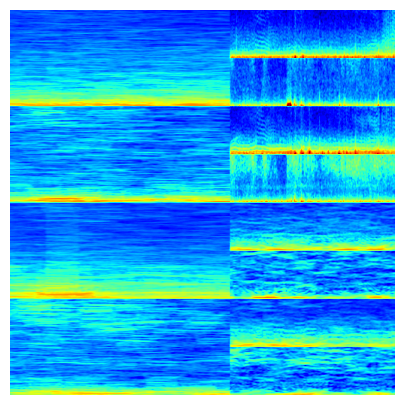

Processing EEGs: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

(512, 512)
CPU times: user 394 ms, sys: 24.2 ms, total: 418 ms
Wall time: 370 ms


In [186]:
%%time
from tqdm import tqdm
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
all_eegs2 = {}
# Make sure the 'images' folder exists
output_folder = 'imagens'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)
print(test.head())

# Creation of spectograms on the test base
for i in tqdm(range(len(test)), desc="Processing EEGs"):
    row = test.iloc[i]
    eeg_id = row['eeg_id']
    spec_id = row['spectrogram_id']
    seconds_min = 0
    start_second = 0
    eeg_data = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/{eeg_id}.parquet')
    eeg_new_key = eeg_id
    image_50s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 50,
                                    low_cut_freq = 0.1, high_cut_freq = 70, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 501,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
    image_10s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 10,
                                    low_cut_freq = 0.1, high_cut_freq = 70, order_band = 5,
                                    spec_size_freq = 100, spec_size_time = 291,
                                    nperseg_ = 260, noverlap_ = 254, nfft_ = 1030,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
    image_10m = create_spectogram_competition(spec_id, seconds_min)
    
    imagem_final_unico_canal = np.zeros((1068, 501))
    for j in range(4):
        inicio = j * 267 
        fim = inicio + 267
        imagem_final_unico_canal[inicio:fim, :] = image_50s[:, :, j]
        
    
    imagem_final_unico_canal2 = np.zeros((400, 291))
    for n in range(4):
        inicio = n * 100 
        fim = inicio + 100
        imagem_final_unico_canal2[inicio:fim, :] = image_10s[:, :, n]
    
    imagem_final_unico_canal_resized = cv2.resize(imagem_final_unico_canal, (400, 800), interpolation=cv2.INTER_AREA)
    imagem_final_unico_canal2_resized = cv2.resize(imagem_final_unico_canal2, (300, 400), interpolation=cv2.INTER_AREA)
    eeg_new_resized = cv2.resize(image_10m, (300, 400), interpolation=cv2.INTER_AREA)
    imagem_final = np.zeros((800, 700), dtype=np.float32)
    imagem_final[0:800, 0:400] = imagem_final_unico_canal_resized
    imagem_final[0:400,400:700] = imagem_final_unico_canal2_resized
    imagem_final[400:800, 400:700] = eeg_new_resized
    imagem_final = imagem_final[::-1]
    
    imagem_final = cv2.resize(imagem_final, (512, 512), interpolation=cv2.INTER_AREA)
    
    all_eegs2[eeg_new_key] = imagem_final
    
    if i ==0:
        plt.figure(figsize=(5, 5))
        plt.imshow(imagem_final, cmap='jet')
        plt.axis('off')
        plt.show()

        print(imagem_final.shape)

In [187]:
import tensorflow as tf

class DataGeneratorTest(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, eegs={}, mode='train'):

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs
        self.mode = mode
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'

        X = np.zeros((len(indexes),SPEC_SIZE[0],SPEC_SIZE[1],SPEC_SIZE[2]),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            eeg_data = self.eegs[row.eeg_id] 
            eeg_data_expanded = np.repeat(eeg_data[:, :, np.newaxis], 3, axis=2)
            X[j,] = eeg_data_expanded
            if self.mode!='test':
                y[j] = row[CLASSES]

        return X,y

In [188]:
# CREATE SUBMISSION.CSV
from IPython.display import display

sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
display( sub.head() )

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.032314,0.047498,0.000148,0.586196,0.011376,0.322468


In [189]:
# INFER MLP ON TEST
preds = []
model = build_EfficientNetB0((SPEC_SIZE[0],SPEC_SIZE[1],SPEC_SIZE[2]), 6)
test_gen = DataGeneratorTest(test, shuffle=False, batch_size=BATCH, eegs=all_eegs2, mode='test')

print('Inferring test... ',end='')
for i in range(FOLDS):
    print(f'fold {i+1}, ',end='')
    model.load_weights(f'/kaggle/input/train-lf-hms/MLP_fold{i}.weights.h5')
    pred = model.predict(test_gen, verbose=0)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Inferring test... fold 1, fold 2, fold 3, fold 4, fold 5, 
Test preds shape (1, 6)


In [190]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
print(sub.iloc[:,-6:].sum(axis=1))

0    1.0
dtype: float32


### Acknowledgements:
* Thank you to @pcjimmmy -  [link](https://www.kaggle.com/code/pcjimmmy/patient-variation-eda)
* Thank you to @cdeotte  - [link](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43)
* Thank you to @seanbearden  - [link](https://www.kaggle.com/code/seanbearden/effnetb0-2-pop-model-train-twice-lb-0-39)